# Forward modeling tutorial using mosaic images
## Extract BeamCutout

Here I will show you how to extract BeamCutouts. Saving these (fits) files before modeling will make entire process quicker. The BeamCutouts contain the orient information which is nessecary for better fitting models. Here's what Gabe says about this from his grizli notebooks:

>To interact more closely with an individual object, its information can be extracted from the full exposure with the BeamCutout class. This object will contain the high-level GrismDisperser object useful for generating the model spectra and it will also have tools for analyzing and fitting the observed spectra.

>It also makes detailed cutouts of the parent direct and grism images preserving the native WCS information.

In [1]:
from grizli import model
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shutil import copy
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import os

## Seaborn is used to make plots look nicer. 
## If you don't have it, you can comment it out and it won't affect the rest of the code
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

hpath = os.environ['HOME'] + '/'


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



## Set files and target

For this example I'll be using one of my quiescent galaxys from GOODS north.

In [2]:
mosaic = hpath + 'Data/CLEAR/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
seg_map = hpath + 'Data/CLEAR/goodsn_3dhstP.seg.fits'
catalog = hpath + 'Data/CLEAR/goodsn_3dhstP.cat'
flt_path = hpath + 'Clear_data/n_flt_files/'
instrument = 'G102' # or G141

galaxy_id = 21156 # 3D-HST catalog ID

## Find flt files with target

You'll need the flt files associated with the field(s) your object's in. You can follow the steps outlined in Raymond's tutorial [grizli_retrieve_and_prep](https://github.com/ivastar/clear/blob/master/notebooks/grizli/grizli_retrieve_and_prep.ipynb) to download flt files. Here I will assume you already have them in hand.

I've created a routine that will search flt files for your an object (given an ra and dec), in case you have flt files from multiple fields.

In [3]:
## Reference catalog
ref_cat = Table.read(catalog,format='ascii')

galaxy_ra = float(ref_cat['ra'][ref_cat['id'] == galaxy_id])
galaxy_dec = float(ref_cat['dec'][ref_cat['id'] == galaxy_id])

In [4]:
## finds source in flt file, returns if present and the position in pixels

def Source_present(fn,ra,dec):  
    flt=fits.open(fn)
    present = False
    
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 < pos[0] < xpixlim and 0 < pos[1] < ypixlim and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
            
    return present,pos

Here I'm searching all of the GOODS north flt's for my target.

If the target is in the file I'll have it print out its [x,y] position, the PA, and the file name

In [5]:
flt_files = glob(flt_path + '*')

grism_flts = []
for i in flt_files:
    in_flt,loc = Source_present(i,galaxy_ra,galaxy_dec)
    if in_flt:
        grism_flts.append(i)
        print('x={0:0.1f} y={1:0.1f}, PA={2:0.1f}, file={3} '.format(
            loc[0],loc[1],fits.open(i)[0].header['PA_V3'], os.path.basename(i)))

x=152.3 y=310.9, PA=345.0, file=icat21cfq_flt.fits 
x=227.3 y=314.4, PA=345.0, file=icat21coq_flt.fits 
x=158.8 y=320.9, PA=345.0, file=icat21dgq_flt.fits 
x=148.8 y=317.4, PA=345.0, file=icat21dlq_flt.fits 
x=-26.3 y=850.8, PA=195.0, file=icat25hcq_flt.fits 
x=-16.3 y=854.3, PA=195.0, file=icat25hiq_flt.fits 
x=-19.8 y=860.8, PA=195.0, file=icat25icq_flt.fits 
x=-29.9 y=857.4, PA=195.0, file=icat25iiq_flt.fits 
x=279.9 y=838.7, PA=345.0, file=icxt51jvq_flt.fits 
x=289.9 y=842.2, PA=345.0, file=icxt51jwq_flt.fits 
x=286.4 y=848.7, PA=345.0, file=icxt51jzq_flt.fits 
x=276.4 y=845.2, PA=345.0, file=icxt51k1q_flt.fits 
x=128.7 y=708.3, PA=308.9, file=icxt52i0q_flt.fits 
x=138.7 y=711.8, PA=308.9, file=icxt52i1q_flt.fits 
x=135.1 y=718.3, PA=308.9, file=icxt52i4q_flt.fits 
x=125.1 y=714.9, PA=308.9, file=icxt52i6q_flt.fits 
x=128.7 y=708.2, PA=308.9, file=icxt53i9q_flt.fits 
x=138.7 y=711.7, PA=308.9, file=icxt53iaq_flt.fits 
x=135.2 y=718.3, PA=308.9, file=icxt53idq_flt.fits 
x=125.2 y=71

In [6]:
## For this example I chose one flt from each of the PAs
## I have included these flts in the flt_files directory

orient_1 = flt_path + 'icxta4mdq_flt.fits' ; PA_1 = 22.0
orient_2 = flt_path + 'icat25iiq_flt.fits' ; PA_2 = 195.0
orient_3 = flt_path + 'icxt53i9q_flt.fits' ; PA_3 = 308.9
orient_4 = flt_path + 'icat21dgq_flt.fits' ; PA_4 = 345.0

## G141 pointings
g141_path = hpath + 'Data/CLEAR/g141_flts/'
orient_5 = g141_path + 'ib3721xiq_flt.fits' ; PA_5 = 345.0
orient_6 = g141_path + 'ib3725e2q_flt.fits' ; PA_6 = 188.3

## Use Grizli to extract beam

First you'll need to create a GrismFLT object. 

Next run blot_catalog to create the catalog of objects in the field. 
Another routine (photutils_detection) is used if you're not using mosiac images and segmentation maps, 
but since we have them you should do it this way.

In [7]:
## GrismFLT object
flt = model.GrismFLT(grism_file = orient_3,
                    ref_file = mosaic, 
                    seg_file = seg_map,
                    force_grism = instrument)
    
## catalog / semetation image
seg_cat = flt.blot_catalog(ref_cat, sextractor=False)

Image cutout: x=slice(8654, 13137, None), y=slice(8309, 12389, None)
/Users/vestrada/Clear_data/n_flt_files/icxt53i9q_flt.fits / blot reference /Users/vestrada/Data/CLEAR/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol
Using default C-based coordinate transformation...
Image cutout: x=slice(8654, 13137, None), y=slice(8309, 12389, None)
/Users/vestrada/Clear_data/n_flt_files/icxt53i9q_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/Clear_data/n_flt_files/icxt53i9q_flt.fits / blot segmentation 

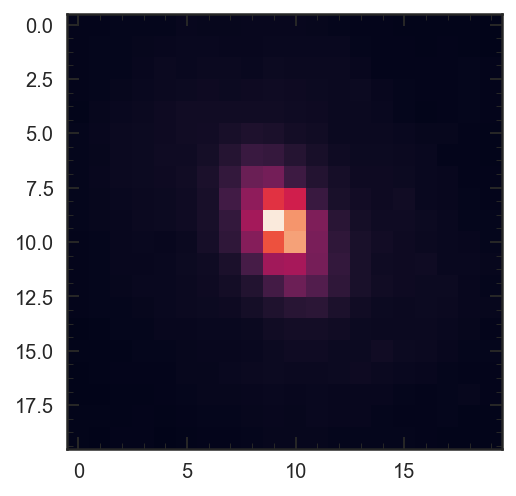

In [8]:
## needed to create the object_disperers dictionary
flt.compute_model_orders(id=galaxy_id)

## Object and spectral order
beam = flt.object_dispersers[galaxy_id][2]['A']

## BeamCutout object
co = model.BeamCutout(flt, beam, conf=flt.conf)

## galaxy cutout from mosiac
plt.imshow(beam.direct)

The last step is to save out the BeamCutout as a fits file.

Here I've added an additional step to save the EXPTIME keyword to extension 0 in the fits file. This may not be nessecary for everyone.

In [11]:
## Save file and ID by orient/PA
co.write_fits(root='beams/o{0}'.format(PA_3), clobber=True)

# add EXPTIME to extension 0
fits.setval('beams/o{0}_{1}.{2}.A.fits'.format(PA_3, galaxy_id, instrument), 'EXPTIME', ext=0,
        value=fits.open('beams/o{0}_{1}.{2}.A.fits'.format(PA_3, galaxy_id, instrument))[1].header['EXPTIME'])

## Function

I've also included a function that can do all of this for you.

In [11]:
def Extract_BeamCutout(galaxy_id, grism_file, mosaic, seg_map, instrument, catalog, show_target=True):
    ## initialize GrismFLT
    flt = model.GrismFLT(grism_file = grism_file ,
                        ref_file = mosaic, seg_file = seg_map,
                        force_grism = instrument)
    
    ## get catalog
    ref_cat = Table.read(catalog ,format='ascii')
    seg_cat = flt.blot_catalog(ref_cat,sextractor=False)
    
    ## create cutout
    flt.compute_model_orders(id=galaxy_id)
    beam = flt.object_dispersers[galaxy_id][2]['A']
    co = model.BeamCutout(flt, beam, conf=flt.conf)
    
    ## get orient/PA
    PA = np.round(fits.open(grism_file)[0].header['PA_V3'] , 1)
    
    ## save file
    co.write_fits(root='beams/o{0}'.format(PA), clobber=True)

    ## add EXPTIME to extension 0
    fits.setval('beams/o{0}_{1}.{2}.A.fits'.format(PA, galaxy_id, instrument), 'EXPTIME', ext=0,
            value=fits.open('beams/o{0}_{1}.{2}.A.fits'.format(PA, galaxy_id, instrument))[1].header['EXPTIME'])
    
    ## show plot
    if show_target:
        plt.figure(figsize=[6,6])
        plt.imshow(beam.direct)

Image cutout: x=slice(8132, 13096, None), y=slice(8041, 13253, None)
flt_files/icxta4mdq_flt.fits / blot reference /Users/vestrada/Data/CLEAR/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(8132, 13096, None), y=slice(8041, 13253, None)
flt_files/icxta4mdq_flt.fits / Pad ref HDU with 50 pixels
flt_files/icxta4mdq_flt.fits / blot segmentation /Users/vestrada/Data/CLEAR/goodsn_3dhstP.seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(6290, 11502, None), y=slice(7321, 12709, None)
flt_files/icat25iiq_flt.fits / blot reference /Users/vestrada/Data/CLEAR/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(6290, 11502, None), y=slice(7321, 12709, None)
flt_files/icat25iiq_flt.fits / Pad ref HDU with 50 pixels
flt_files/icat25iiq_flt.fits / blot segmentation /Users/vestra

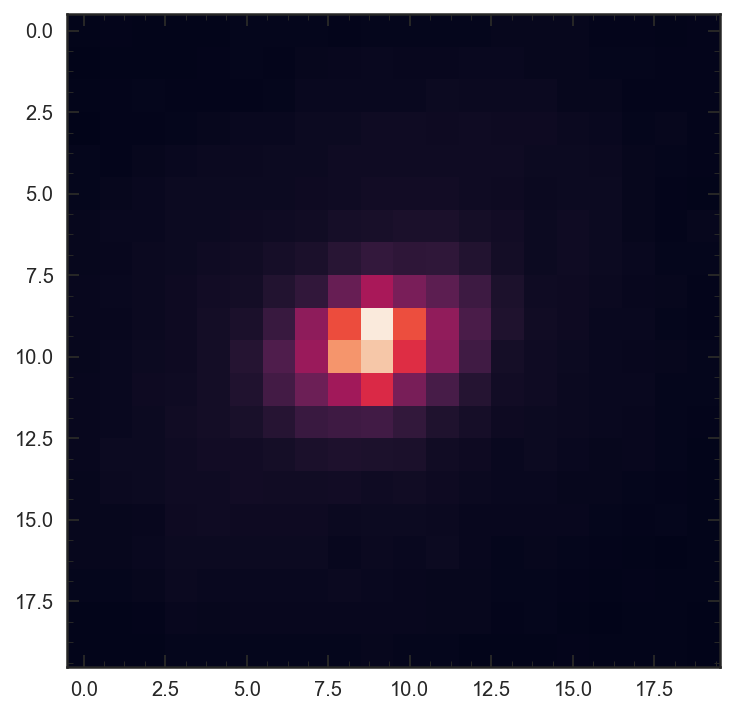

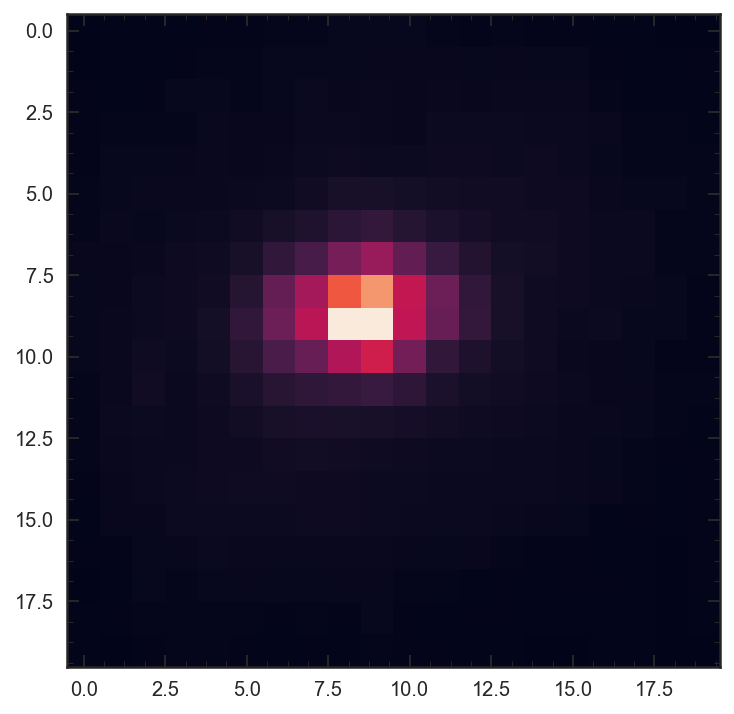

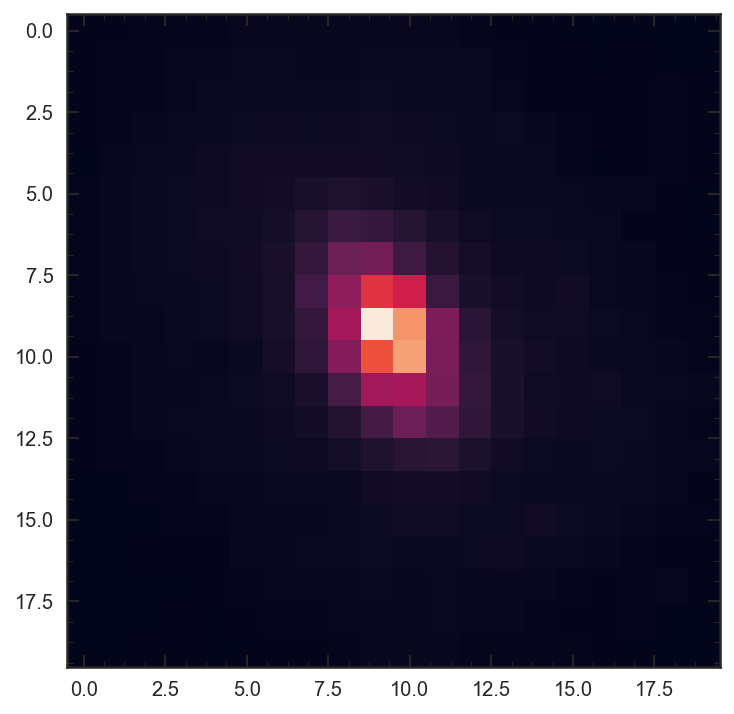

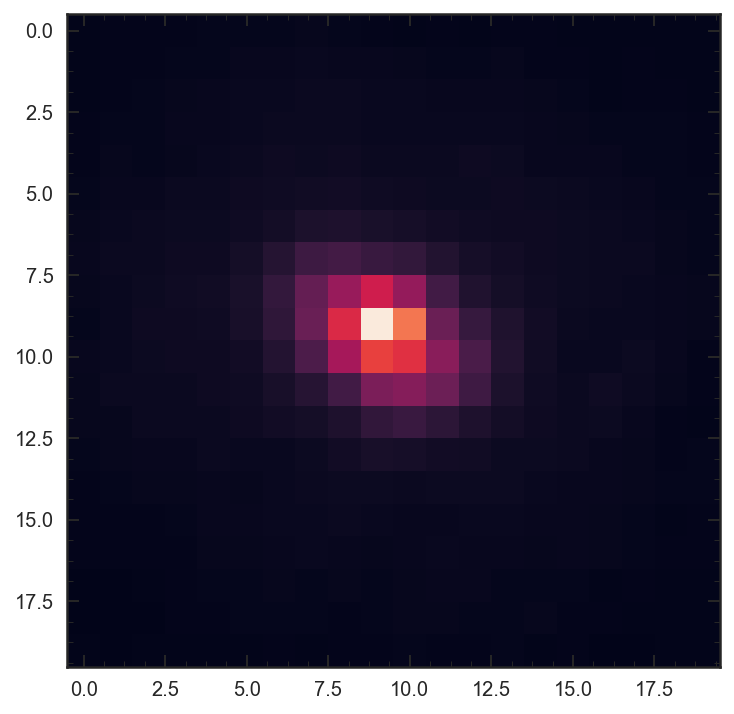

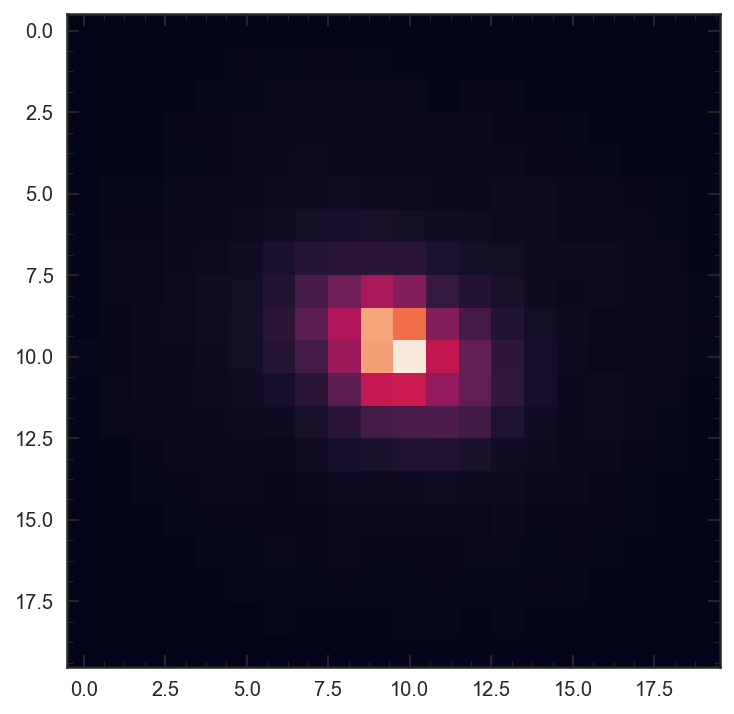

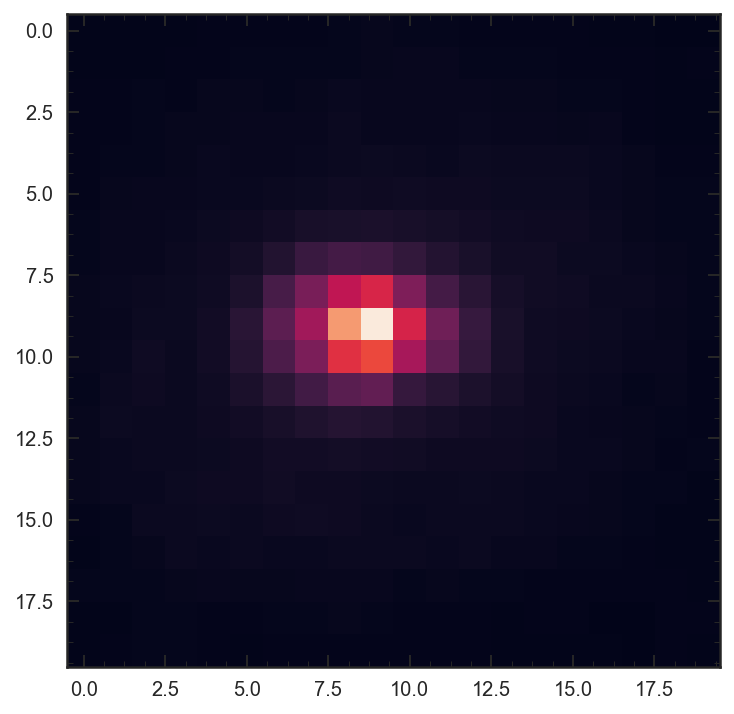

In [27]:
Extract_BeamCutout(21156,orient_1,mosaic,seg_map,'g102',catalog)
Extract_BeamCutout(21156,orient_2,mosaic,seg_map,'g102',catalog)
Extract_BeamCutout(21156,orient_3,mosaic,seg_map,'g102',catalog)
Extract_BeamCutout(21156,orient_4,mosaic,seg_map,'g102',catalog)
Extract_BeamCutout(21156,orient_5,mosaic,seg_map,'g141',catalog)
Extract_BeamCutout(21156,orient_6,mosaic,seg_map,'g141',catalog)

## Extracting MultiBeam

Another way to to extract beam cutouts is to use the MultiBeam object. This methond has the advantage of containing **all** 
grism pointing information (incorporating both G102 and G141).

In [13]:
from grizli import multifit

In [22]:
## The GroupFLT object uses all grism flts for the target
grism_flts = glob('flt_files/*')
grp = multifit.GroupFLT(grism_files = grism_flts, direct_files = [], 
              ref_file = mosaic,
              seg_file = seg_map,
              catalog = catalog,
              cpu_count = 2,verbose = False)

Image cutout: x=slice(7792, 13149, None), y=slice(8993, 14206, None)
Image cutout: x=slice(7784, 13141, None), y=slice(8985, 14198, None)
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(7792, 13149, None), y=slice(8993, 14206, None)
Image cutout: x=slice(7784, 13141, None), y=slice(8985, 14198, None)
flt_files/ib3721xiq_flt.fits / Pad ref HDU with 50 pixels
flt_files/ib3721xmq_flt.fits / Pad ref HDU with 50 pixels
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(7793, 13150, None), y=slice(8980, 14194, None)
Image cutout: x=slice(7800, 13157, None), y=slice(8988, 14201, None)
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(7793, 13150, None), y=slice(8980, 14194,

In [23]:
## Pull out the 2D cutouts
beams = grp.get_beams(21156, size=80)

## MultiBeam will read in all the beams and the main way to interact
## with the models. Since we're only interested in using this for creating models
## we don't need to worry about the rest of the settings
mb = multifit.MultiBeam(beams, group_name='beams/gnd')

# Save a FITS file with the 2D cutouts (beams) from the individual exposures
mb.write_master_fits(verbose=False)